# NaiveBayes

In [14]:
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics as mt

def procesar_csv(df):
    from sklearn import preprocessing
    # convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = origin_as_int
    df.drop('destination', axis=1, inplace=True)
    
    # Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del tiempo a unix time stamp para medir la distancia de forma mas facil.
    df["date_departure_int"] = pd.to_datetime(df["date"].map(str)+" "+df["departure_time"], errors='coerce')
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

In [15]:
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")
# Procesamos los datos con la funcion procesar_csv()
df = procesar_csv(df)
# transformamos los datos a binarios
df["Labels"] = np.where(df["noshow"] >= 4, 1,0)
# Definimos nuestra columna target
target = df['Labels']
# La eliminamos del dataframe
df.drop('noshow', axis=1, inplace=True)


#Columnas despues de la limpieza
df.columns

Index(['fligth_number', 'distance', 'denied_boarding', 'pax_midlow',
       'pax_high', 'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'out_of_stock', 'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'bookings',
       'origin_int', 'destination_int', 'revenues_usd_discr',
       'date_departure_int', 'Labels'],
      dtype='object')

In [16]:
display(df)
df.info()

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr,date_departure_int,Labels
0,8995,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240,12,12,6,2009-11-09 10:30:00,1
1,7061,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220,79,79,2,2009-05-23 19:20:00,0
2,8972,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79,122,122,8,2011-05-09 09:54:00,1
3,6039,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90,27,27,6,2010-02-12 21:00:00,1
4,7713,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209,51,51,8,2009-10-24 12:40:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,6024,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73,143,143,8,2009-10-16 15:14:00,1
999886,6669,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274,79,79,10,2009-05-03 08:50:00,1
999887,9094,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131,62,62,7,2011-04-04 14:18:00,1
999888,7704,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134,53,53,5,2009-04-04 08:05:00,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 998472 entries, 0 to 999889
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fligth_number       998472 non-null  int64         
 1   distance            998472 non-null  int64         
 2   denied_boarding     998472 non-null  int64         
 3   pax_midlow          998472 non-null  int64         
 4   pax_high            998472 non-null  int64         
 5   pax_midhigh         998472 non-null  int64         
 6   pax_low             998472 non-null  int64         
 7   pax_freqflyer       998472 non-null  int64         
 8   group_bookings      998472 non-null  int64         
 9   out_of_stock        998472 non-null  int64         
 10  dom_cnx             998472 non-null  int64         
 11  int_cnx             998472 non-null  int64         
 12  p2p                 998472 non-null  int64         
 13  capacity            998472 no

In [17]:
#Cree un objeto de KFold cross validation
kf = KFold(n_splits = 25, shuffle = True, random_state = 0)

#Cree arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).

AccuracyTrain = np.zeros(25)
AccuracyTest = np.zeros(25)

RecallTrain = np.zeros(25)
RecallTest = np.zeros(25)

PrecisionTrain = np.zeros(25)
PrecisionTest = np.zeros(25)

F1Train = np.zeros(25)
F1Test = np.zeros(25)

#Cree el objeto de Naive Bayes que estime correspondiente, con el alpha deseado

NB = GaussianNB(var_smoothing = 1)
i=0
#Aplique K-fold cross validation
for train_index, test_index in kf.split(df):#Complete
        #extraiga los datos de entrenamiento y test
        trainData = df.iloc[train_index, :]
        testData = df.iloc[test_index, :]

        trainLabel = target.iloc[train_index]
        testLabel = target.iloc[test_index]

        #Entrene el modelo usando los datos de entrenamiento
        NB = NB.fit(trainData, trainLabel)

        #Prediga los valores de TrainData y calcule su error
        prediccion = NB.predict(trainData)
        F1Train[i] = mt.f1_score(trainLabel, prediccion)
        AccuracyTrain[i] = mt.accuracy_score(trainLabel, prediccion)
        RecallTrain[i] = mt.accuracy_score(trainLabel, prediccion)
        PrecisionTrain[i] = mt.accuracy_score(trainLabel, prediccion)

        #Prediga los valores de testData y calcule su error
        prediccion = NB.predict(testData)
        F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 1)
        #AccuracyTest[i] = mt.accuracy_score(trainLabel, prediccion)
        #RecallTest[i] = mt.accuracy_score(trainLabel, prediccion)
        #PrecisionTest[i] = mt.accuracy_score(trainLabel, prediccion)
        i+=1
        
print("Numero iteraciónes: ", i)
print("F1-score modelo para training: ", F1Train.mean(), "+-", F1Train.std())   
print("F1-score modelo para test: ", F1Test.mean(), "+-", F1Test.std())  

#print(f"Accuracy: {AccuracyTest.mean()}")
#print(f"Precicion para 1: {PrecisionTest.mean()}")
#print(f"Recall score: {RecallTest.mean()}")
#print(f"f1 Score: {f1Test.mean()}")

C:\Users\matia\anaconda3\lib\site-packages\sklearn\utils\validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


TypeError: float() argument must be a string or a number, not 'Timestamp'

In [35]:
#Muestre la media y desviación estandar de cada error 
print("F1-score modelo para training: ", errorTrain.mean(), "+-", errorTrain.std())   
print("F1-score modelo para test: ", errorTest.mean(), "+-", errorTest.std())  

F1-score modelo para training:  0.7919559026850831 +- 6.932792844590083e-05
F1-score modelo para test:  0.7919536139428671 +- 0.0016634758175725307


In [54]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df,target,test_size=0.33, random_state=42)


In [75]:
#Creando un objeto Naive Bayes con las condiciones iniciales
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB(var_smoothing = 0.00001)
NB = NB.fit(X_train,y_train)

#Aplicando el modelo a otros datos
resultado=NB.predict(X_test)
print("Resultado de la predicción:\n",resultado)
print("Resultado original:\n",y_test)

#Aplicando el modelo a otros datos
resultados=NB.predict_proba(X_test)
print("Resultado de la predicción:\n",resultados)

Resultado de la predicción:
 [1 1 1 ... 1 1 1]
Resultado original:
 118754    1
557683    1
920464    0
342002    1
795703    0
         ..
437790    1
21087     1
772657    0
276786    0
447843    1
Name: Labels, Length: 329496, dtype: int64
Resultado de la predicción:
 [[0.36538011 0.63461989]
 [0.35333092 0.64666908]
 [0.33329777 0.66670223]
 ...
 [0.31671702 0.68328298]
 [0.43254937 0.56745063]
 [0.19207329 0.80792671]]


In [76]:
mt.f1_score(y_test, resultado, pos_label = 1)

0.7826978436017585

In [73]:
print("Clases:\n",df["Labels"].unique())
print("características:\n",df.columns)
print("\nDistribución a prior (P(C)):\n",NB.class_prior_)
print("\nMedias:\n",NB.theta_)
print("\nDesviación estandar (sqrt de sigma):\n",np.sqrt(NB.sigma_))

Clases:
 [1 0]
características:
 Index(['fligth_number', 'distance', 'denied_boarding', 'pax_midlow',
       'pax_high', 'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'out_of_stock', 'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'revenues_usd',
       'bookings', 'origin_int', 'destination_int', 'date_departure_int',
       'Labels'],
      dtype='object')

Distribución a prior (P(C)):
 [0.34448321 0.65551679]

Medias:
 [[5.82191942e+03 1.47606202e+03 6.30589583e-02 7.38713306e+01
  3.78970801e+00 6.04682991e+00 5.11962543e+01 1.58840665e+01
  4.97485366e+00 9.88843615e-02 2.55039943e+01 2.97408213e+01
  9.55433736e+01 1.72642640e+02 1.49416131e+04 1.50788189e+02
  6.07777445e+01 6.07777445e+01 1.81057661e+01 0.00000000e+00]
 [6.26479195e+03 1.45397872e+03 3.90468046e-02 7.63725512e+01
  3.82651160e+00 6.47302434e+00 6.04029554e+01 1.72695810e+01
  3.22839519e+00 9.47243601e-02 2.59631059e+01 2.51640864e+01
  1.13217431e+02 1.80960970e+02 1.47894523e+04 1.64344623e+02


,distance,capacity
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
9995,0.0,0.0
9996,0.0,0.0
9997,0.0,0.0
9998,0.0,0.0


,distance,capacity
0,3971.924427,2595.662927
1,-935.772666,2437.282524
2,-520.113967,1020.739384
3,-4713.026487,1305.653326
4,-603.658574,-1378.419416
...,...,...
9995,1240.124888,3426.559557
9996,508.717667,1889.825044
9997,2605.382205,1975.488617
9998,3293.542443,-624.316292


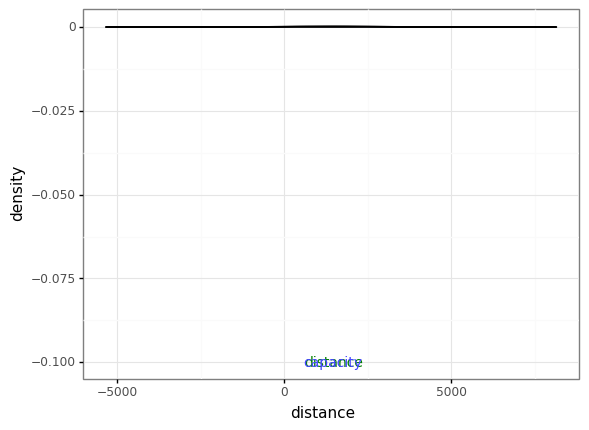

<ggplot: (8736828223067)>

In [65]:
#Visualización de las distribuciones
tempDF=pd.DataFrame(np.zeros((10000,2)),columns=['distance','capacity'])
varSeleccionada=1
display(tempDF)
for i in range(2):
    tempDF.iloc[:,i] = np.random.normal(NB.theta_[i][varSeleccionada], np.sqrt(NB.sigma_[i][varSeleccionada]), 10000)
display(tempDF)
    
(ggplot(tempDF)+theme_bw()+
 geom_density(aes(x='distance'),fill="#007F00",alpha=0.5)+
 geom_density(aes(x='capacity'),fill="#4446FF",alpha=0.5)+
 #geom_density(aes(x='bookings'),fill="#C41A16",alpha=0.5)+
 annotate("text",x=tempDF.distance.mean(),y=-0.1,label="distance",color="#007F00",size=10)+
 annotate("text",x=tempDF.capacity.mean(),y=-0.1,label="capacity",color="#4446FF",size=10)+
 #annotate("text",x=tempDF.bookings.mean(),y=-0.1,label="bookings",color="#C41A16",size=10)+ 
 labs(y="density",x=df.columns[varSeleccionada])
)